##Ingest

### Install packages

In [3]:
!pip install scikit-surprise

  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise


In [0]:
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, SVD, evaluate
import seaborn as sns
import matplotlib.pyplot as plt

###Load data

Load customer rating data

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/fangqiqiqi/Discussion2/master/Class%20Movie%20Data.csv', 
                 header = 0)

In [28]:
df.head(10)

,Customer ID,Movie ID,Rating
0,1,1,3.0
1,1,2,NaN
2,1,3,NaN
3,1,4,4.0
4,1,5,5.0
5,1,6,4.0
6,1,7,5.0
7,1,8,NaN
8,1,9,NaN
9,1,10,NaN


Drop missing values

In [32]:
df = df[pd.notnull(df['Rating'])]
df.head(10)

,Customer ID,Movie ID,Rating
0,1,1,3.0
3,1,4,4.0
4,1,5,5.0
5,1,6,4.0
6,1,7,5.0
11,1,12,3.0
18,1,19,3.0
19,1,20,4.0
20,1,21,3.0
21,1,22,4.0


Load mapping data

In [33]:
df_title = pd.read_csv('https://raw.githubusercontent.com/fangqiqiqi/Discussion2/master/Movie%20Names.csv', 
                       header = 0)
df_title.set_index('Movie ID', inplace = True)
df_title.head(10)

,Movie Name
Movie ID,
1,The Social Network
2,A Prophet
3,Amour
4,The King's Speech
5,La La Land
6,Boyhood
7,Inception
8,A Separation
9,The Artist


##EDA

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


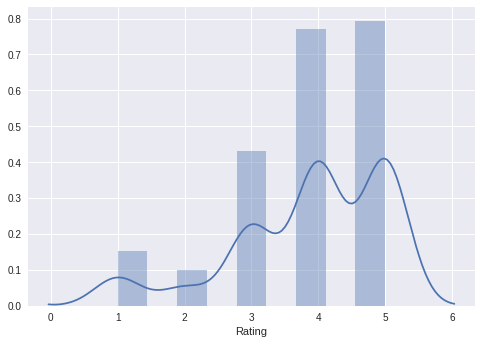

In [34]:
sns.distplot(df['Rating'])

In [56]:
dfbymovie = df.groupby('Movie ID').count()[['Rating']]
dfby = dfbymovie.sort_values(by='Rating', ascending = False)
dfby.head(10)

,Rating
Movie ID,
12,35
5,32
35,32
7,31
39,25
1,23
47,21
49,20
4,20


##Recommand model

###Recommend with Collaborative Filtering

In [9]:
reader = Reader()

data = Dataset.load_from_df(df[['Customer ID', 'Movie ID', 'Rating']], reader)
data.split(n_folds=3)

svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8735
MAE:  0.7425
------------
Fold 2
RMSE: 0.9161
MAE:  0.7611
------------
Fold 3
RMSE: 0.8376
MAE:  0.6833
------------
------------
Mean RMSE: 0.8757
Mean MAE : 0.7290
------------
------------


/usr/local/lib/python3.6/dist-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.7425207260396035,
                             0.7611421342326651,
                             0.6832816884362387],
                            'rmse': [0.8735488162650414,
                             0.9161424332417865,
                             0.8375514508286164]})

In [10]:
df_29 = df[(df['Customer ID'] == 29)]
movie_list = df[(df['Customer ID'] == 29)]
df_29 = df_29.set_index('Movie ID')
df_29 = df_29.join(df_title)['Movie Name']
df_29

Movie ID
5                                     La La Land
7                                      Inception
12                                        Avatar
19                                 Up in the Air
29     Three Billboards Outside Ebbing, Missouri
32                                    Black Swan
35                       The Wolf of Wall Street
44                                       Dunkirk
49                            The Imitation Game
Name: Movie Name, dtype: object

In [11]:
drop_movie_list = movie_list['Movie ID']
drop_movie_list

1404     5
1406     7
1411    12
1418    19
1428    29
1431    32
1434    35
1443    44
1448    49
Name: Movie ID, dtype: int64

In [12]:
user_29 = df_title.copy()
user_29 = user_29.reset_index()
#user_29 = user_29[~user_29['Movie ID'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Customer ID', 'Movie ID', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.train(trainset)

user_29['Estimate_Score'] = user_29['Movie ID'].apply(lambda x: svd.predict(29, x).est)

user_29 = user_29.drop('Movie ID', axis = 1)

user_29 = user_29.sort_values('Estimate_Score', ascending=False)
print(user_29)

/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


                                    Movie Name  Estimate_Score
6                                    Inception        4.510113
11                                      Avatar        4.264824
48                          The Imitation Game        4.208704
4                                   La La Land        4.158222
29                                        Argo        4.143948
3                            The King's Speech        4.131292
9                             The White Ribbon        4.106930
42                    The Grand Budapest Hotel        4.096869
31                                  Black Swan        4.072064
28   Three Billboards Outside Ebbing, Missouri        4.064395
46                                 Toy Story 3        4.032360
38                                  Life of Pi        4.023941
15                            12 Years a Slave        4.023406
39                                     Arrival        3.974185
19                        Inglourious Basterds        3

###Recommend with Pearsons' R correlations

In [0]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie ID')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)

In [14]:
df_p = pd.pivot_table(df,values='Rating',index='Customer ID',columns='Movie ID')

print(df_p.shape)

(42, 47)


In [0]:
df_title['Movie Name'] = df_title['Movie Name'].apply(lambda x: x.strip())

In [16]:
df_title[df_title['Movie Name']=='The Fighter']

,Movie Name
Movie ID,
50,The Fighter


In [0]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Movie Name'] == movie_title] [0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Movie Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [18]:
recommend("La La Land", 0)

For movie (La La Land)
- Top 10 movies recommended based on Pearsons'R correlation - 
PearsonR                   Movie Name  count      mean
                                                      
     1.0                     Precious      3  3.333333
     1.0                 A Separation      3  3.333333
     1.0     The Secret in Their Eyes      2  2.500000
     1.0   Blue is the Warmest Colour      2  2.500000
     1.0                 Toni Erdmann      2  2.500000
     1.0                        Amour      2  2.500000
     1.0          Inside Llewyn Davis      2  2.500000
     1.0  Beasts of the Southern Wild      2  2.500000
     1.0                   La La Land     32  4.187500
     1.0                          Ida      3  3.000000


In [19]:
recommend("Avatar", 0)

For movie (Avatar)
- Top 10 movies recommended based on Pearsons'R correlation - 
PearsonR                   Movie Name  count      mean
                                                      
1.000000  Beasts of the Southern Wild      2  2.500000
1.000000          Inside Llewyn Davis      2  2.500000
1.000000     The Secret in Their Eyes      2  2.500000
1.000000                 Toni Erdmann      2  2.500000
1.000000                        Amour      2  2.500000
1.000000   Blue is the Warmest Colour      2  2.500000
1.000000                   The Artist      2  3.000000
1.000000             The White Ribbon      2  3.500000
1.000000                       Avatar     35  4.142857
0.981981             The Tree of Life      3  2.666667


##Conclusion

1.	The majority of ratings are concentrated on 4 and 5 scores.
2.	The two methods are based on different principles, one is to calculate the score of other films by similarity, the other is to find out which movies are most related to the favorite movies through the correlation between them. The predicted results obtained by different methods are not completely consistent.

